In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import scipy.misc as mis
from skimage.transform import resize
from skimage import data

%matplotlib inline

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [45]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])
train_set_x_flatten = np.concatenate((train_set_x_flatten.T, test_set_x_flatten.T), axis=0).T
train_set_y = np.concatenate((train_set_y,test_set_y),axis=1)
num_px = train_set_x_orig.shape[1]

In [46]:
#define the sigmoid activation function for output layer
def sigmoid(z):
  return 1/(1 + np.exp(-z))

In [47]:
#initialize the parameters for 2 hidden layers
def initialize_parameters(n_x, n_h1, n_h2, n_h3, n_y):
  
  #We do random assignment to parameters instead of zero
  W1 = np.random.randn(n_h1, n_x)
  b1 = np.random.randn(n_h1, 1)
  W2 = np.random.randn(n_h2, n_h1)
  b2 = np.random.randn(n_h2, 1)
  W3 = np.random.randn(n_h3, n_h2)
  b3 = np.random.randn(n_h3, 1)
  W4 = np.random.randn(n_y, n_h3)
  b4 = np.random.randn(n_y, 1)
    
  parameters = {
    "W1": W1,
    "b1" : b1,
    "W2": W2,
    "b2" : b2,
    "W3": W3,
    "b3" : b3,
    "W4": W4,
    "b4" : b4
  }
  return parameters

In [48]:
#perform forward propagation
def forward_prop(X, parameters):
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  W3 = parameters["W3"]
  b3 = parameters["b3"]
  W4 = parameters["W4"]
  b4 = parameters["b4"]
    
  #b is resized by broadcasting

  #tanh is used as activation ftn for hidden layers and sigmoid for output layer
  Z1 = np.dot(W1, X) + b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = np.tanh(Z2) 
  Z3 = np.dot(W3, A2) + b3
  A3 = np.tanh(Z3) 
  Z4 = np.dot(W4, A3) + b4
  A4 = sigmoid(Z4)
  
  #cache is used in back propagation
  cache = {
    "A1": A1,
    "A2": A2,
    "A3": A3,
    "A4": A4,      
  }
  return A4, cache

In [49]:
#determine the loss function to retune the parameters
def calculate_cost(A4, Y):
    
  #cost ftn of logisitic regression
  cost = -np.sum(np.multiply(Y, np.log(A4)) +  np.multiply(1-Y, np.log(1-A4)))/m
  cost = np.squeeze(cost)

  return cost

In [50]:
#perform back propagation
def backward_prop(X, Y, cache, parameters):
  A1 = cache["A1"]
  A2 = cache["A2"]
  A3 = cache["A3"]
  A4 = cache["A4"]

  W2 = parameters["W2"]
  W3 = parameters["W3"]
  W4 = parameters["W4"]

  #backpropagation for output layer
  dZ4 = A4 - Y
  dW4 = np.dot(dZ4, A3.T)/m
  db4 = np.sum(dZ4, axis=1, keepdims=True)/m

  #backpropagation for 3rd hidden layer
  dZ3 = np.multiply(np.dot(W4.T, dZ4), 1-np.power(A3, 2))
  dW3 = np.dot(dZ3, A2.T)/m
  db3 = np.sum(dZ3, axis=1, keepdims=True)/m

  #backpropagation for 2nd hidden layer
  dZ2 = np.multiply(np.dot(W3.T, dZ3), 1-np.power(A2, 2))
  dW2 = np.dot(dZ2, A1.T)/m
  db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    
  #backpropagation for 1st hidden layer 
  dZ1 = np.multiply(np.dot(W2.T, dZ2), 1-np.power(A1, 2))
  dW1 = np.dot(dZ1, X.T)/m
  db1 = np.sum(dZ1, axis=1, keepdims=True)/m

  grads = {
    "dW1": dW1,
    "db1": db1,
    "dW2": dW2,
    "db2": db2,
    "dW3": dW3,
    "db3": db3,
    "dW4": dW4,
    "db4": db4      
  }

  return grads

In [51]:
#We update the parameters
def update_parameters(parameters, grads, learning_rate):
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  W3 = parameters["W3"]
  b3 = parameters["b3"]
  W4 = parameters["W4"]
  b4 = parameters["b4"]
    
  dW1 = grads["dW1"]
  db1 = grads["db1"]
  dW2 = grads["dW2"]
  db2 = grads["db2"]
  dW3 = grads["dW3"]
  db3 = grads["db3"]
  dW4 = grads["dW4"]
  db4 = grads["db4"]
    
  #performing gradient descenet
  W1 = W1 - learning_rate * dW1
  b1 = b1 - learning_rate * db1
  W2 = W2 - learning_rate * dW2
  b2 = b2 - learning_rate * db2
  W3 = W3 - learning_rate * dW3
  b3 = b3 - learning_rate * db3
  W4 = W4 - learning_rate * dW4
  b4 = b4 - learning_rate * db4

  new_parameters = {
    "W1": W1,
    "W2": W2,
    "W3": W3,
    "W4": W4,
    "b1" : b1,
    "b2" : b2,
    "b3" : b3,
    "b4" : b4
  }

  return new_parameters

In [52]:
#model to run neural network
def model(X, Y, n_x, n_h1, n_h2, n_h3, n_y, num_of_iters, learning_rate):
  parameters = initialize_parameters(n_x, n_h1, n_h2, n_h3, n_y)

  #Running the model for a number of iterations
  for i in range(0, num_of_iters+1):
    a2, cache = forward_prop(X, parameters)

    cost = calculate_cost(a2, Y)

    grads = backward_prop(X, Y, cache, parameters)

    parameters = update_parameters(parameters, grads, learning_rate)

    if(i % 100 == 0):
      print('Cost after iteration# {:d}: {:f}'.format(i, cost))

  return parameters

In [53]:
#model for prediction
def predict(X, parameters):
  a2, cache = forward_prop(X, parameters)
  yhat = a2
  yhat = np.squeeze(yhat)

  #If prediction is more than 0.5 we classify as 1 otherwise as 0
  if(yhat >= 0.5):
    y_predict = 1
  else:
    y_predict = 0

  return y_predict

In [54]:
#main code starts here
if __name__ == "__main__":
    np.random.seed(2)

    X = train_set_x_flatten
    Y = train_set_y
    
    m = X.shape[1]

    # Set the hyperparameters
    n_x = 12288      #No. of neurons in first layer
    n_h1 = 128     #No. of neurons in 1st hidden layer
    n_h2 = 32     #No. of neurons in 2nd hidden layer
    n_h3 = 32     #No. of neurons in 2nd hidden layer
    n_y = 1      #No. of neurons in output layer
    num_of_iters = 1000
    learning_rate = 1
    
    trained_parameters = model(X, Y, n_x, n_h1, n_h2, n_h3, n_y, num_of_iters, learning_rate)

Cost after iteration# 0: 1.824865
Cost after iteration# 100: 0.049298
Cost after iteration# 200: 0.021560
Cost after iteration# 300: 0.014396
Cost after iteration# 400: 0.011302
Cost after iteration# 500: 0.004994
Cost after iteration# 600: 0.003788
Cost after iteration# 700: 0.003105
Cost after iteration# 800: 0.002637
Cost after iteration# 900: 0.002292
Cost after iteration# 1000: 0.002026


Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Non-Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Cat"
Neural Network prediction is "Cat"
Neural Network prediction 

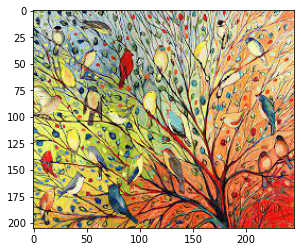

In [55]:
for i in range(1,51):
    my_image = "test" + str(i) + ".jpg"
    fname = "images/" + my_image

    img= Image.open(fname)
    np_img = np.array(img)
    image = np_img/255.
    my_image = resize(image, (num_px,num_px)).reshape((num_px*num_px*3,1))
    y_predict = int(predict(my_image, trained_parameters))
    if (y_predict == 1):
        print('Neural Network prediction is "Cat"')
    else:
        print('Neural Network prediction is "Non-Cat"')

    plt.imshow(image)

In [56]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(1,51):
    my_image = "test" + str(i) + ".jpg"
    fname = "images/" + my_image
    img= Image.open(fname)
    np_img = np.array(img)
    image = np_img/255.
    my_image = resize(image, (num_px,num_px)).reshape((num_px*num_px*3,1))
    y_predict = int(predict(my_image, trained_parameters))
    y_hat = 0
    if (i < 26):
        y_hat = 1

    if ((y_hat == 1) & (y_predict == 1)):
        tp = tp + 1
    
    else: 
        if ((y_hat == 0) & (y_predict == 0)):
            tn = tn + 1

        else: 
            if ((y_hat == 1) & (y_predict == 0)):
                fn = fn + 1

            else: 
                if ((y_hat == 0) & (y_predict == 1)):
                    fp = fp + 1    

print("{:d} {:d} \n{:d} {:d}" .format(tp,fp,fn,tn))

9 12 
16 13


In [57]:
total = 0
sum = 0
for i in range(len(test_set_x_flatten.T)):
    y_predict = predict(test_set_x_flatten.T[i].reshape((test_set_x_flatten.shape[0]),1), trained_parameters)
    y_hat = test_set_y.T[i][0]
    if (y_predict == y_hat):
        sum = sum + 1
    total = total + 1
    
print(sum*100/total)

100.0


In [58]:
total = 0
sum = 0
for i in range(len(train_set_x_flatten.T)):
    y_predict = predict(train_set_x_flatten.T[i].reshape((train_set_x_flatten.shape[0]),1), trained_parameters)
    y_hat = train_set_y.T[i][0]
    if (y_predict == y_hat):
        sum = sum + 1
    total = total + 1
    
print(sum*100/total)

100.0
